# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
conn = sqlite3.connect('../input/database.sqlite')
filtered_data = pd.read_sql_query(''' SELECT * FROM REVIEWS LIMIT 100000''', conn)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
# samplingCount = findMinorClassPoints(filtered_data)
# postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=5000)
# negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=5000)

# filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."


## Data Preprocessing

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

100%|██████████| 88461/88461 [00:01<00:00, 56663.24it/s]


Segregating the input and output data from the dataset.

We will be using the Cleaned Text i.e preprocessed data from the dataset and score for that text

In [4]:
X = final['CleanedText']
y = final['Score']

In [5]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

### Splitting the data

In [6]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (56614,)
Shape of Output - Train: (56614,)
Shape of Input  - CV   : (14154,)
Shape of Output - CV   : (14154,)
Shape of Input  - Test : (17693,)
Shape of Output - Test : (17693,)


### Tokenizing the dataset

In [7]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[9, 46, 6, 2027, 1818, 3, 2502, 3, 1697, 14, 121, 94, 40, 128, 945, 5, 53, 225, 171, 8, 4, 829, 57, 1, 313, 444, 2, 311, 2019, 16, 11, 54, 14, 6, 4, 26, 215, 12, 382, 9, 46, 53, 118, 5, 168, 3, 247, 7, 551, 13, 541, 1472, 178, 135, 1309, 4, 2753, 3051, 47, 4, 340, 46, 81, 178, 139, 8, 1, 6, 823, 444, 18, 8, 1, 747, 65, 655, 119, 11, 630, 46, 266, 9, 300, 6, 4, 229, 1063, 46, 35, 808]
56614


### Padding the dataset

This is just to give batch input to the RNN

In [8]:
# truncate and/or pad input sequences
max_review_length = 1000
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(56614, 1000)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [9]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

### Model M1 ( Embedding -> LSTM -> Output(Sigmoid) ) 

In [10]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

Instructions for updating:
Colocations handled automatically by placer.
***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Instructions for updating:
Use tf.cast instead.
Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 154s 3ms/step - loss: 0.3626 - acc: 0.8625 - val_loss: 0.2282 - val_acc: 0.9000
Epoch 2/5
56614/56614 [==============================] - 152s 3ms/step - loss: 0.1901 - acc: 0.9211 - val_loss: 0.1972 - val_acc: 0.9184
Epoch 3/5
56614/56614 [==============================] - 152s 3ms/step - loss: 0.1792 - acc: 0.9263 - val_loss: 0.2079 - val_acc: 0.9126
Epoch 4/5
56614/56614 [==============================] - 152s 3ms/step - loss: 0.1692 - acc: 0.9311 - val_loss: 0.1960 - val_acc: 0.9171
Epoch 5/5
17693/17693 [==============================] - 15s 871us/step
Test score: 0.19941727656365546
Test accuracy: 0.9197987909537473


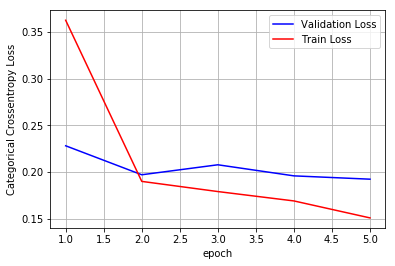

In [11]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M2 ( Embedding -> LSTM -> Dropout -> Dense(128-Relu) -> Dropout -> Dense (64-Relu) -> Dropout -> Output(Sigmoid) ) 

In [12]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)   

Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 154s 3ms/step - loss: 0.3486 - acc: 0.8666 - val_loss: 0.2037 - val_acc: 0.9095
Epoch 2/5
56614/56614 [==============================] - 153s 3ms/step - loss: 0.1862 - acc: 0.9255 - val_loss: 0.1882 - val_acc: 0.9201
Epoch 3/5
56614/56614 [==============================] - 153s 3ms/step - loss: 0.1636 - acc: 0.9359 - val_loss: 0.1974 - val_acc: 0.9193
Epoch 4/5
56614/56614 [==============================] - 153s 3ms/step - loss: 0.1559 - acc: 0.9384 - val_loss: 0.2107 - val_acc: 0.9200
Epoch 5/5
17693/17693 [==============================] - 15s 864us/step
Test score: 0.20497340852693577
Test accuracy: 0.916011982321746


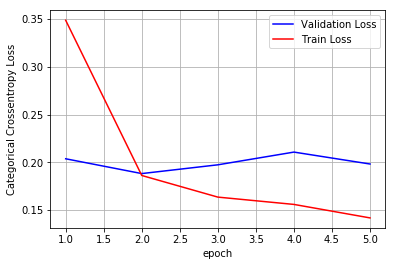

In [13]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 2,
                                    "Architecture": 'Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M3 ( Embedding -> LSTM -> LSTM -> Output(Sigmoid) ) 

In [14]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 100)         53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 307s 5ms/step - loss: 0.3385 - acc: 0.8720 - val_loss: 0.2059 - val_acc: 0.9115
Epoch 2/5
56614/56614 [==============================] - 306s 5ms/step - loss: 0.1803 - acc: 0.9266 - val_loss: 0.1906 - val_acc: 0.9196
Epoch 3/5
56614/56614 [==============================] - 306s 5ms/step - loss: 0.1594 - acc: 0.9355 - val_loss: 0.1936 - val_acc: 0.9187
Epoch 4/5
56614/56614 [==============================] - 306s 5ms/step - loss: 0.1482 - acc: 0.9407 - val_loss: 0.1899 - val_acc: 0.9207
Epoch 5/5
17693/17693 [==============================] - 31s 2ms/step
Test score: 0.2099661622818616
Test accuracy: 0.9195727120015537


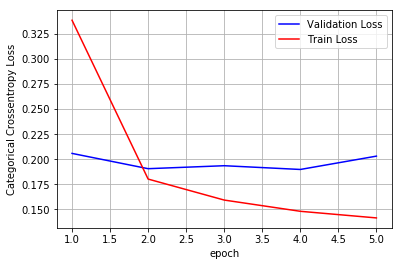

In [15]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 3,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [16]:
final_output

,Model,Architecture,TRAIN_LOSS,TEST_LOSS,TRAIN_ACC,TEST_ACC
0,1,Embedding-LSTM-Sigmoid,0.15100,0.19942,0.93926,0.91980
1,2,Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid,0.14182,0.20497,0.94461,0.91601
2,3,Embedding-LSTM-LSTM-Sigmoid,0.14161,0.20997,0.94367,0.91957


Here,

The dataset which we used is Amazon fine food reviews dataset.
There are a couple different models that we tried -
* Model 1 was having architecture with one LSTM layer.
* Model 2 was having architecture with one LSTM layer, intermediate dropouts set to 0.5 and 2 dense hidden layers with ReLU activation
* Model 3 was having architecture with 2 LSTM layers.

Conclusion that can be drawn from the above models is that
All the models are performing great in terms of execution. All of them are converging very faster.

Though Model 3 with 2 LSTM layers converges a little bit faster but it is requiring more training time.